# 分层智能体团队（Hierarchical Agent Teams）

## 环境配置（Setup）

In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")
_set_env("DEEPSEEK_API_KEY")
_set_env("TAVILY_API_KEY")
# DeepSeek API基础地址
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"

## 创建工具（Create Tools）

### 研究团队工具（ResearchTeam tools）

In [2]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_tavily import TavilySearch
from langchain_core.tools import tool

tavily_tool = TavilySearch(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """使用 requests 和 bs4 爬取指定网页，获取详细信息。"""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


### 文档撰写团队工具（Document writing team tools）

In [3]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

# 系统自动创建临时目录
_TEMP_DIRECTORY = TemporaryDirectory()
# 临时目录路径
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(
    points: Annotated[List[str], "主要要点或章节列表。"],
    file_name: Annotated[str, "用于保存大纲的文件路径。"],
) -> Annotated[str, "保存的大纲文件路径。"]:
    """创建并保存大纲。"""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"大纲已保存至 {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "待读取文档的文件路径。"],
    start: Annotated[Optional[int], "起始行，默认值为 0"] = None,
    end: Annotated[Optional[int], "结束行，默认值为 None"] = None,
) -> str:
    """读取指定文档。"""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
        if start is None:
            start = 0
        return "\n".join(lines[start:end])

@tool
def write_document(
    content: Annotated[str, "要写入文档的文本内容。"],
    file_name: Annotated[str, "用于保存文档的文件路径。"],
) -> Annotated[str, "保存的文档文件路径。"]:
    """创建并保存文本文档。"""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"文档已保存至 {file_name}"

@tool
def edit_document(
    file_name: Annotated[str, "待编辑文档的路径。"],
    inserts: Annotated[
        Dict[int, str],
        "字典，键为行号（从 1 开始计数），值为要插入该行的文本。",
    ],
) -> Annotated[str, "编辑后的文档文件路径。"]:
    """通过在特定行号插入文本编辑文档。"""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    sorted_inserts = sorted(inserts.items())
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"错误：行号 {line_number} 超出范围。"
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)
    return f"文档已编辑并保存至 {file_name}"

# 警告：此工具会在本地执行代码，若未进行沙箱隔离，可能存在安全风险
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "用于生成图表的 Python 代码。"],
):
    """使用此工具执行 Python 代码。若需查看某个值的输出，
    请使用 `print(...)` 打印该值。执行结果对用户可见。"""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"执行失败。错误信息：{repr(e)}"
    return f"执行成功：\n```python\n{code}\n```\n标准输出：{result}"

## 辅助工具（Helper Utilities）

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, SystemMessage

class State(MessagesState):
    next: str

# def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
#     options = ["FINISH"] + members
#     system_prompt = (
#         "你是一名管理者，负责协调以下工作智能体之间的协作："
#         f"{members}。根据用户的请求，"
#         "指定下一个执行任务的智能体。每个智能体完成任务后，"
#         "会返回结果和状态。任务全部完成后，回复 FINISH。"
#     )

#     class Router(TypedDict):
#         """下一个要分配任务的智能体。若无需其他智能体参与，返回 FINISH。"""
#         next: Literal[*options]

#     def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
#         """基于大语言模型的路由工具。"""
#         messages = [
#             {"role": "system", "content": system_prompt},
#         ] + state["messages"]
#         response = llm.with_structured_output(Router).invoke(messages)
#         goto = response["next"]
#         if goto == "FINISH":
#             goto = END
#         return Command(goto=goto, update={"next": goto})

#     return supervisor_node

def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    # 优化提示词：明确任务终止条件和决策逻辑
    system_prompt = (
        "你是监督者，负责管理工具协作以完成用户任务。\n"
        "工作原则：\n"
        "1. 分析当前信息是否足够回答用户问题：\n"
        "   - 若信息模糊、不完整或仅为概览，必须调用更擅长深入解析的工具；\n"
        "   - 若信息已具体、充分，返回FINISH。\n"
        "2. 工具选择逻辑：\n"
        "   - 若当前结果包含可深入解析的线索（如链接、文档引用），优先选择能处理这类线索的工具；\n"
        "   - 避免重复调用同一类功能的工具（例如连续用概览类工具）。\n"
        "3. 优先从可用工具[{members}]中选择，或返回FINISH。\n"
        "4. 当用户请求模糊或无对应工作团队能处理时，不调用任何团队，直接回复用户，并返回FINISH。\n"
        "输出格式：仅返回JSON {{\"next\": \"工具名或FINISH\"}}，无其他内容。"
    ).format(members=", ".join(members))

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        # 提取历史消息中最后一个工具的输出（用于判断是否重复调用）
        last_node = None
        if state["messages"]:
            last_msg = state["messages"][-1]
            if hasattr(last_msg, "name"):
                last_node = last_msg.name  # 获取上一个执行的节点名
                
        # 构建消息
        messages = [
            SystemMessage(content=system_prompt),
            *state["messages"]  # 传入历史消息
        ]
        # 调用Deepseek（无结构化输出，直接获取文本）
        response = llm.invoke(messages).content.strip()

        # 手动解析JSON（关键适配步骤）
        try:
            import json
            result = json.loads(response)
            goto = result["next"]

            # 避免连续调用同一节点（关键优化）
            if goto == last_node and goto in members:
                # 若重复调用，切换到下一个可用节点
                next_idx = members.index(goto) + 1
                goto = members[next_idx] if next_idx < len(members) else "FINISH"
        except:
            # 解析失败时，若上一个是search则切换到web_scraper，否则用第一个节点
            goto = members[1] if (last_node == members[0] and len(members)>=2) else members[0] if members else "FINISH"

        if goto == "FINISH":
            goto = END
        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## 定义智能体团队（Define Agent Teams）

### 研究团队（Research Team）

In [24]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# llm = ChatOpenAI(model="gpt-4o")
llm = ChatOpenAI(
    model="deepseek-chat",  # DeepSeek对话模型
    temperature=0,
    api_key=os.environ["DEEPSEEK_API_KEY"],
    base_url=DEEPSEEK_BASE_URL,
)

search_agent = create_react_agent(llm, tools=[tavily_tool])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # 工作智能体完成任务后，需始终向管理者汇报
        goto="supervisor",
    )

web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # 工作智能体完成任务后，需始终向管理者汇报
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

/var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/ipykernel_73604/3365028204.py:13: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  search_agent = create_react_agent(llm, tools=[tavily_tool])
/var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/ipykernel_73604/3365028204.py:27: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


In [25]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

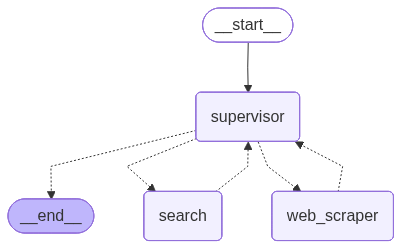

In [26]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [27]:
# for s in research_graph.stream(
#     {"messages": [("user", "泰勒·斯威夫特的下一场巡演是什么时候？")]},
#     {"recursion_limit": 100},
# ):
#     print(s)
#     print("---")
try:
    # 流式执行查询
    for step in research_graph.stream(
        # {"messages": [("user", "现在是2025年10月30日，后弦下一场演唱会是什么时候？")]},
        {"messages": [("user", "现在是2025年10月30日，后弦最近的演唱会是什么时候？如果你不清楚，请去大麦网查看过后再告诉我，我需要详细的购票链接")]},
        # {"messages": [("user", "when is Taylor Swift's next tour?")]},
        # {"messages": [("user", "https://www.kuaiplanet.com/ 快行星是什么网站？")]},
        {"recursion_limit": 100},
    ):
        # 打印当前步骤的智能体和结果
        for node, output in step.items():
            print(f"【{node}】执行结果：")
            if "messages" in output:
                print(output["messages"][-1].content)
            elif "next" in output:
                print(f"下一步：{output['next']}")
        print("---")
except Exception as e:
    print(f"执行出错：{str(e)}")
    # 打印详细错误信息（便于调试）
    import traceback
    traceback.print_exc()

【supervisor】执行结果：
下一步：search
---
【search】执行结果：
根据我搜索到的信息，我为您找到了后弦最近的演唱会信息：

## 后弦最近的演唱会信息

**后弦2025「从你的青春路过」2.0全国巡回演唱会-北京站**

- **演出时间**：2025年8月23日 周六 19:30
- **演出地点**：北京展览馆剧场（北京市）
- **门票价格**：328元/528元/699元/999元/1199元
- **开票时间**：2025年8月2日 12:21

## 购票渠道

**主要官方售票平台：**
- **大麦网** - 官方主售票渠道
- **猫眼** - 官方合作售票平台

## 详细购票链接

**大麦网官方购票渠道：**
- **PC端**：https://www.damai.cn
- **手机APP**：下载"大麦"APP
- **移动端**：https://m.damai.cn
- **小程序**：支付宝小程序、微信小程序、抖音小程序、百度小程序

**其他官方渠道：**
- 天猫大麦网官方旗舰店
- 淘票票

## 重要提示

1. **购票时间**：请关注2025年8月2日12:21的开票时间
2. **限购政策**：每单最多购买6张票
3. **支付时限**：下单后需在15分钟内完成支付
4. **实名认证**：建议提前完成大麦网账户的实名认证

由于现在是2025年10月30日，这场北京演唱会已经结束。建议您关注后弦的官方社交媒体账号或大麦网，获取最新的巡演信息，可能会有新的场次安排。
---
【supervisor】执行结果：
下一步：__end__
---


### 文档撰写团队（Document Writing Team）

In [28]:
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "你可以根据记录员的大纲读取、撰写和编辑文档。"
        "无需提出后续问题。"
    ),
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # 工作智能体完成任务后，需始终向管理者汇报
        goto="supervisor",
    )

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "你可以读取文档并为文档撰写者创建大纲。"
        "无需提出后续问题。"
    ),
)

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # 工作智能体完成任务后，需始终向管理者汇报
        goto="supervisor",
    )

chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)

def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # 工作智能体完成任务后，需始终向管理者汇报
        goto="supervisor",
    )

doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

/var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/ipykernel_73604/850819351.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  doc_writer_agent = create_react_agent(
/var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/ipykernel_73604/850819351.py:22: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  note_taking_agent = create_react_agent(
/var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/ipykernel_73604/850819351.py:43: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_generating_agent = create_re

In [29]:
# 在此处创建图表
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)
paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

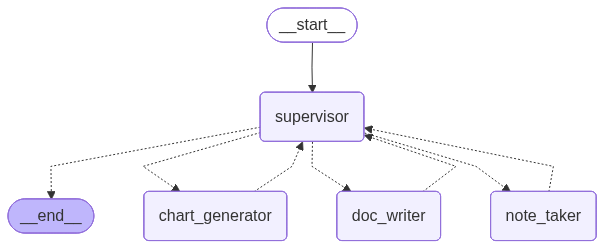

In [30]:
from IPython.display import Image, display
display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [31]:
# for s in paper_writing_graph.stream(
#     {
#         "messages": [
#             (
#                 "user",
#                 "Write an outline for poem about cats and then write the poem to disk.",
#             )
#         ]
#     },
#     {"recursion_limit": 100},
# ):
#     print(s)
#     print("---")
try:
    # 流式执行任务
    for step in paper_writing_graph.stream(
        {
            "messages": [
                (
                    "user",
                    "撰写一首关于猫的诗歌大纲，然后将诗歌写入文件。",
                )
            ]
        },
        {"recursion_limit": 100},
    ):
        # 清晰展示每个节点的执行情况
        for node_name, result in step.items():
            print(f"=== 节点: {node_name} ===")
            if "next" in result:
                print(f"下一步操作: {result['next']}")
            if "messages" in result:
                print("输出内容:")
                print(result["messages"][-1].content)
        print("-" * 50)
except Exception as e:
    print(f"执行出错: {str(e)}")
    # 输出详细错误堆栈（便于调试）
    import traceback
    traceback.print_exc()

=== 节点: supervisor ===
下一步操作: doc_writer
--------------------------------------------------
=== 节点: doc_writer ===
输出内容:
我已经成功完成了任务：

1. **创建了诗歌大纲**：在"猫的诗歌大纲.txt"文件中，我详细规划了诗歌的结构，包括引言、外貌描写、性格特点、生活场景、情感表达和结尾升华六个部分。

2. **撰写了完整诗歌**：在"猫咪之歌.txt"文件中，我根据大纲创作了一首完整的诗歌，描绘了猫咪的神秘优雅、外貌特征、性格特点、生活场景以及与人类的情感联系，最后以温暖的祝福结尾。

诗歌采用了优美的语言和生动的意象，充分展现了猫咪的魅力。您可以通过读取这两个文件来查看完整内容。
--------------------------------------------------
=== 节点: supervisor ===
下一步操作: __end__
--------------------------------------------------


## 添加层级（Add Layers）

In [32]:
from langchain_core.messages import BaseMessage

# 创建顶层监督者节点：管理 research_team 和 writing_team 两个子团队
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [33]:
# 定义调用研究团队的节点逻辑
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    # 调用研究团队的状态图，传入最新消息
    response = research_graph.invoke({"messages": state["messages"][-1]})
    # 返回命令：更新消息（添加研究结果），路由回顶层监督者
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )

# 定义调用文档写作团队的节点逻辑
def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    # 调用文档写作团队的状态图，传入最新消息
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    # 返回命令：更新消息（添加写作结果），路由回顶层监督者
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

# 构建顶层协调状态图
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)  # 顶层监督者节点
super_builder.add_node("research_team", call_research_team)  # 研究团队调用节点
super_builder.add_node("writing_team", call_paper_writing_team)  # 写作团队调用节点
super_builder.add_edge(START, "supervisor")  # 起始节点为顶层监督者
super_graph = super_builder.compile()  # 编译顶层图

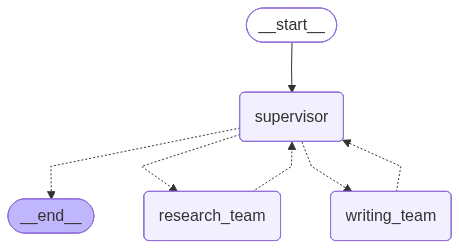

In [34]:
# 可视化顶层图
from IPython.display import Image, display
display(Image(super_graph.get_graph().draw_mermaid_png()))

In [42]:
# 测试整个分层系统：研究 AI 智能体并撰写简要报告
# for s in super_graph.stream(
#     {
#         "messages": [
#             ("user", "Research AI agents and write a brief report about them.")
#         ],
#     },
#     {"recursion_limit": 150},
# ):
#     print(s)
#     print("---")
try:
    # 流式执行任务
    for step in super_graph.stream(
        {
            "messages": [
                (
                    "user",
                    # "您好",
                    # "先帮我查看下周上海的天气，得到数据后输出折线图。",
                    # "调研一下AI agents的研究进展，并写一份简要的报告，将报告写入文件",
                    # "Research AI agents and write a brief report about them.",
                    "帮我搜一下迪丽热巴最近有什么新剧，去豆瓣查看一下评分，生成柱状图",
                )
            ]
        },
        {"recursion_limit": 150},
    ):
        # 清晰展示每个节点的执行情况
        for node_name, result in step.items():
            print(f"=== 节点: {node_name} ===")
            if "next" in result:
                print(f"下一步操作: {result['next']}")
            if "messages" in result:
                print("输出内容:")
                print(result["messages"][-1].content)
        print("-" * 50)
except Exception as e:
    print(f"执行出错: {str(e)}")
    # 输出详细错误堆栈（便于调试）
    import traceback
    traceback.print_exc()

=== 节点: supervisor ===
下一步操作: research_team
--------------------------------------------------
=== 节点: research_team ===
输出内容:
基于搜索到的信息，我来为您整理迪丽热巴最近几部剧的豆瓣评分，并生成柱状图：

## 迪丽热巴最近几部剧的豆瓣评分

根据搜索结果，迪丽热巴最近几部剧的豆瓣评分如下：

| 剧名 | 播出年份 | 豆瓣评分 |
|------|----------|----------|
| 《安乐传》 | 2023年 | 5.6分 |
| 《公诉》 | 2023年 | 6.6分 |
| 《与君初相识·恰似故人归》 | 2022年 | 5.7分 |
| 《长歌行》 | 2021年 | 6.1分 |

## 豆瓣评分柱状图

```
迪丽热巴最近几部剧豆瓣评分对比

7.0 ┤
6.5 ┤        █
6.0 ┤    █
5.5 ┤  █  █
5.0 ┤
    └─────────────
     安乐传 公诉 与君初相识 长歌行
```

## 分析总结

1. **评分表现**：
   - 《公诉》评分最高（6.6分），是迪丽热巴转型正剧的尝试
   - 《长歌行》评分中等（6.1分）
   - 《安乐传》和《与君初相识·恰似故人归》评分相对较低，都在5.6-5.7分之间

2. **作品类型**：
   - 古装剧占多数（3部）
   - 现代剧只有《公诉》一部
   - 评分显示迪丽热巴在现代正剧中的表现获得了相对更好的评价

3. **发展趋势**：
   - 从2021年到2023年，迪丽热巴的作品评分波动较大
   - 2023年两部作品评分差异明显，显示她在不同类型剧集中的表现差异

总体来说，迪丽热巴在演艺事业上持续活跃，每年都有新作品推出，但在豆瓣评分方面表现参差不齐，现代正剧《公诉》获得了相对较好的评价。
--------------------------------------------------
=== 节点: supervisor ===
下一步操作: __end__
--------------------------------------------------


In [36]:
# 打印工作目录（一次性查看）
print("工作目录路径：", WORKING_DIRECTORY.absolute())

工作目录路径： /var/folders/z1/znf_twcx4j54gdsr0l9r4vtr0000gn/T/tmp9d_ckr6u


In [ ]:
# 查看单个包的版本（例如 langchain、langchain-core 等）
import langchain
import langgraph
import langchain_core
import langchain_community
import langchain_openai
import chromadb
import pydantic
import langchain_tavily
from importlib.metadata import version

print("langchain 版本：", langchain.__version__)
print("langgraph 版本：", version("langgraph"))
print("langchain-core 版本：", langchain_core.__version__)
print("langchain-community 版本：", langchain_community.__version__)
print("langchain-openai 版本：", version("langchain-openai"))
print("chromadb 版本：", chromadb.__version__)
print("pydantic 版本：", pydantic.__version__)
print("langchain-tavily 版本：", langchain_tavily.__version__)